# Austrian energy system Tutorial Part 1: Building an Energy Model

For information on how to install *MESSAGEix*, please refer to [Installation page](https://docs.messageix.org/en/stable/#getting-started), and for getting the *MESSAGEix* tutorials, please follow the steps mentioned in [Tutorials](https://docs.messageix.org/en/stable/tutorials.html).

Please refer to the [user guidelines](https://github.com/iiasa/message_ix/blob/master/NOTICE.rst)
for additional information on using *MESSAGEix*, including the recommended citation and how to name new models.

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working

**Structure of these tutorials.** After having run this baseline tutorial, you are able to start with any of the other tutorials, but we recommend to follow the order below for going through the information step-wise:

1. Prepare the base model version (Python: ``austria.ipynb``, also available in R: ``austria_reticulate.ipynb``)
2. Plot the results of the baseline runs (Python: ``austria_load_scenario.ipynb``, also available in R: ``austria_load_scenario_R.ipynb``)
3. Run a single policy scenario (``austria_single_policy.ipynb``)
4. Run multiple policy scenarios. This tutorial has two notebooks: an introduction with some exercises and completed code for the exercises (exercises: ``austria_multiple_policies.ipynb``, answers: ``austria_multiple_policies-answers.ipynb``)

**Introduction**

In this notebook, we will build a model of the Austrian energy system from scratch. The process will involve defining our model's time horizon and spatial extent, and then populating the model with data associated with model parameters. Once we have a baseline model, we will then move on to investigating policy scenarios.

We will be populating different kinds of parameters including:

### Economic Parameters

- `interestrate`
- `demand`

### Technology Parameters

#### Engineering Parameters

- `input`
- `output`
- `technical_lifetime`
- `capacity_factor`


#### Technoeconomic Parameters

- `inv_cost`
- `fix_cost`
- `var_cost`

### Dynamic Behavior Parameters

- `bound_activity_up`
- `bound_activity_lo`
- `bound_new_capacity_up`
- `initial_activity_up`
- `growth_activity_up`

### Emissions

- `emission_factor`

A full list of parameters can be found in the [MESSAGEix documentation](http://messageix.iiasa.ac.at/model/MESSAGE/parameter_def.html). (If you have cloned the MESSAGEix [Github repository](https://github.com/iiasa/message_ix), the documentation can also be built offline; see `doc/README.md`.) 

## The Final Product

At the completion of this exercise, we will have developed an energy model that is comprised of the below Reference Energy System (RES):

![title](austria.png)



## Setup

In [1]:
# load required packages 
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp as ix
import message_ix

from message_ix.util import make_df

In [2]:
# launch the IX modeling platform using the local default database
mp = ix.Platform(name="default", jvmargs=["-Duser.language=en"])

2025-04-06 12:09:01,345  INFO at.ac.iiasa.ixmp.Platform:165 - Welcome to the IX modeling platform!
2025-04-06 12:09:01,350  INFO at.ac.iiasa.ixmp.Platform:166 -  connected to database 'jdbc:hsqldb:file:/home/ggungor/.local/share/ixmp/localdb/default' (user: ixmp)...


In [3]:
model = "Turkey energy model"
scen = "baseline"
annot = "developing a stylized energy system model for illustration and testing" 

# scenario = message_ix.Scenario(mp, model, scen, version='new', annotation=annot)
scenario = message_ix.Scenario(mp, model, scen, annotation=annot)

## Time and Spatial Detail

The model includes the time periods 2020, 2025, 2030, 2035, 2040, 2045 and 2050.

In [10]:
horizon = range(2020, 2051, 5)
scenario.add_horizon(year=horizon)

ValueError: Scenario has year=[2020, 2025, 2030, 2035, 2040, 2045, 2050] and related values

In [11]:
scenario.vintage_and_active_years()

,year_vtg,year_act
0,2020,2020
1,2020,2025
2,2020,2030
3,2020,2035
4,2020,2040
5,2020,2045
6,2020,2050
7,2025,2025
8,2025,2030
9,2025,2035


In [12]:
country = 'Turkey'
scenario.add_spatial_sets({'country': country})

In [13]:
scenario.set("node")

0     World
1    Turkey
dtype: object

## Model Structure

In [14]:
scenario.add_set("commodity", ["electricity", "light_and_appliance", "hvac"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("mode", "standard")

In [15]:
scenario.set("commodity")

0            electricity
1    light_and_appliance
2                   hvac
dtype: object

## Economic Parameters

Definition of the socio-economic discount rate:

In [16]:
scenario.add_par("interestrate", horizon, value=0.10, unit='-')

The fundamental premise of the model is to satisfy demand for energy (services). To first order, demands for services (e.g. electricity) track with economic productivity (GDP). Therefore, as a simple example, we define both a GDP profile and a correlation parameter between GDP growth and demand, called beta. Beta will then be used to obtain a simplistic demand profile.

The socio-economic forecasts are taken from the [IIASA SSP](https://data.ece.iiasa.ac.at/ssp/#/downloads) database.

In [17]:
import pyam

# by default, you receive the latest SSP projections (2024 release)
df = pyam.read_iiasa("ssp", region="Turkey", variable="GDP|PPP")

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.iiasa - INFO: You are connected to the IXSE_SSP scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ssp/#/about
pyam.iiasa - INFO: You are connected as an anonymous user


In [18]:
df.variable

['GDP|PPP']

/home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


<Axes: title={'center': 'region: Turkey - variable: GDP|PPP'}, xlabel='Year', ylabel='billion USD_2017/yr'>

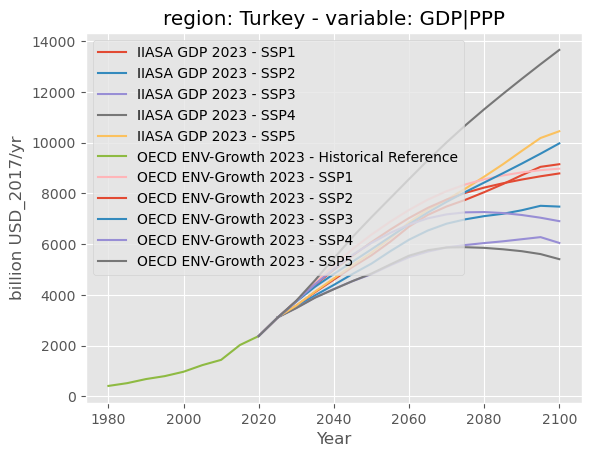

In [19]:
df.plot()

In [20]:
df.filter(scenario="SSP5").head(6)

,model,scenario,region,variable,unit,year,value
0,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2025,3109.770706
1,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2030,3579.607376
2,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2035,4130.312535
3,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2040,4647.478636
4,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2045,5173.939204
5,IIASA GDP 2023,SSP5,Turkey,GDP|PPP,billion USD_2017/yr,2050,5665.413737


The base year GDP|PPP is taken from [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.PP.CD?locations=TR) database.

In [21]:
gdp = pd.Series([2390, 3109.770706, 3579.607376, 4130.312535, 4647.478636, 5173.939204, 5665.413737], index=horizon)
beta = 0.7
demand = 1.116 * gdp ** beta

In [22]:
demand.head()

2020    258.548918
2025    310.866592
2030    343.043323
2035    379.185949
2040    411.828479
dtype: float64

<Axes: >

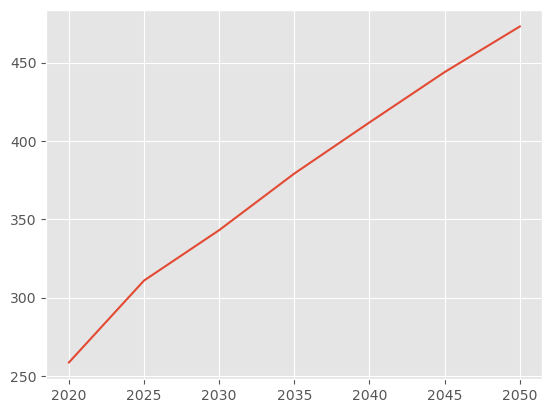

In [23]:
demand.plot()

## Technologies

In [24]:
plants = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "geothermal",
    "solar_pv_ppl", # actually primary -> final
]
secondary_energy_techs = plants + ['import']

final_energy_techs = ['electricity_grid']

# lights actually includes lights and household appliances
light_and_appliance = [
    "low_efficiency", 
    "high_efficiency", 
]
useful_energy_techs = light_and_appliance + ['hvac']

In [25]:
technologies = secondary_energy_techs + final_energy_techs + useful_energy_techs
scenario.add_set("technology", technologies)

In [26]:
scenario.set("technology")

0             coal_ppl
1              gas_ppl
2              oil_ppl
3              bio_ppl
4            hydro_ppl
5             wind_ppl
6           geothermal
7         solar_pv_ppl
8               import
9     electricity_grid
10      low_efficiency
11     high_efficiency
12                hvac
dtype: object

# Electricity consumption by end-uses, 2022

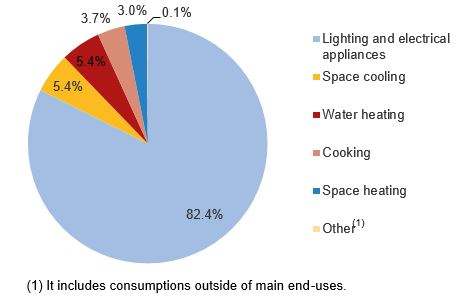
[TURKSTAT Corporate](https://data.tuik.gov.tr/Bulten/Index?p=Final-Energy-Consumption-Statistics-in-Households-2022-53805&dil=2)

In [27]:
demand_per_year = (1-0.824) / 8.76
elec_demand = pd.DataFrame({
        'node': country,
        'commodity': 'hvac',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': demand_per_year * demand,
        'unit': 'GWa',
    })
scenario.add_par("demand", elec_demand)

demand_per_year = 0.824 / 8.76
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light_and_appliance',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': demand_per_year * demand,
        'unit': 'GWa',
    })
scenario.add_par("demand", light_demand)

In [28]:
scenario.par("demand")

,node,commodity,level,year,time,value,unit
0,Turkey,hvac,useful,2020,year,5.194590,GWa
1,Turkey,hvac,useful,2025,year,6.245721,GWa
2,Turkey,hvac,useful,2030,year,6.892195,GWa
3,Turkey,hvac,useful,2035,year,7.618348,GWa
4,Turkey,hvac,useful,2040,year,8.274179,GWa
5,Turkey,hvac,useful,2045,year,8.919647,GWa
6,Turkey,hvac,useful,2050,year,9.504623,GWa
7,Turkey,light_and_appliance,useful,2020,year,24.320127,GWa
8,Turkey,light_and_appliance,useful,2025,year,29.241332,GWa
9,Turkey,light_and_appliance,useful,2030,year,32.268002,GWa


### Engineering Parameters

In [29]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

In [30]:
base_input = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'electricity',
    'time': 'year',
    'time_origin': 'year',
}

grid = pd.DataFrame(dict(
        technology = 'electricity_grid',
        level = 'secondary',
        value = 1.0,
        unit = '-',
        **base_input
        ))
scenario.add_par("input", grid)


low_efficiency = pd.DataFrame(dict(
        technology = 'low_efficiency',
        level = 'final',
        value = 1.0,
        unit = '-',
        **base_input
        ))
scenario.add_par("input", low_efficiency)

high_efficiency = pd.DataFrame(dict(
        technology = 'high_efficiency',
        level = 'final',
        value = 0.3, # LED and CFL lighting equipment are more efficient than conventional light bulbs,
                     #so they need less input electricity to produce the same quantity of 'light'
                     #compared to conventional light bulbs (0.3 units vs 1.0, respectively) 
        unit = '-',
        **base_input
        ))
scenario.add_par("input", high_efficiency)

hvac = pd.DataFrame(dict(
        technology = 'hvac',
        level = 'final',
        value = 1.0,
        unit = '-',
        **base_input
        ))
scenario.add_par("input", hvac)

In [31]:
make_df?
# to see what the funcion "make_df" does.

Signature: make_df(name, **data)
Docstring:
Return a data frame for parameter or indexed set `name` filled with `data`.

:func:`make_df` always returns a data frame with the columns required by either:

- :meth:`.add_par`: the dimensions of the parameter `name`, plus 'value' and 'unit'.
- :meth:`.add_set`: the dimensions of the indexed set `name`.

Columns not listed in `data` are left empty.

The `data` keyword arguments can be passed in many ways; see the
:ref:`python:tut-keywordargs` and “Function Examples” sections of the Python
introductory tutorial, or the examples below.

Examples
--------

>>> make_df(
...    "demand", node=["foo", "bar"], commodity="baz", value=[1.2, 3.4]
... )
  node  commodity  level  year  time  value  unit
0  foo        baz   None  None  None    1.2  None
1  bar        baz   None  None  None    3.4  None

Pass some values as direct keyword arguments, and others by unpacking a dictionary:

>>> common = dict(
...    commodity="light",
...    level="useful",


In [32]:
base_output = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_dest': country,
    'time': 'year',
    'time_dest': 'year', 
    'unit': '-',
}

imports = make_df(base_output, technology='import', commodity='electricity', 
                  level='secondary', value=1.)
scenario.add_par('output', imports)

grid = make_df(base_output, technology='electricity_grid', commodity='electricity', 
               level='final', value=0.873)
scenario.add_par('output', grid)

low_efficiency = make_df(base_output, technology='low_efficiency', commodity='light_and_appliance', 
               level='useful', value=1.)
scenario.add_par('output', low_efficiency)

high_efficiency = make_df(base_output, technology='high_efficiency', commodity='light_and_appliance', 
              level='useful', value=1.)
scenario.add_par('output', high_efficiency)

hvac = make_df(base_output, technology='hvac', commodity='hvac', 
              level='useful', value=1.)
scenario.add_par('output', hvac)

coal = make_df(base_output, technology='coal_ppl', commodity='electricity', 
               level='secondary', value=1.)
scenario.add_par('output', coal)

gas = make_df(base_output, technology='gas_ppl', commodity='electricity', 
              level='secondary', value=1.)
scenario.add_par('output', gas)

oil = make_df(base_output, technology='oil_ppl', commodity='electricity', 
              level='secondary', value=1.)
scenario.add_par('output', oil)

bio = make_df(base_output, technology='bio_ppl', commodity='electricity', 
              level='secondary', value=1.)
scenario.add_par('output', bio)

hydro = make_df(base_output, technology='hydro_ppl', commodity='electricity', 
                level='secondary', value=1.)
scenario.add_par('output', hydro)

wind = make_df(base_output, technology='wind_ppl', commodity='electricity', 
               level='secondary', value=1.)
scenario.add_par('output', wind)

solar_pv = make_df(base_output, technology='solar_pv_ppl', commodity='electricity', 
                   level='final', value=1.)
scenario.add_par('output', solar_pv)

geothermal = make_df(base_output, technology='geothermal', commodity='electricity', 
                   level='final', value=1.)
scenario.add_par('output', geothermal)

In [33]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

lifetimes = {
    'coal_ppl': 40,
    'gas_ppl': 30,
    'oil_ppl': 30,
    'bio_ppl': 30,
    'hydro_ppl': 60,
    'wind_ppl': 20,
    'solar_pv_ppl': 20,
    'geothermal':20,
    'low_efficiency': 1,
    'high_efficiency': 10,
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

# Turkey Energy Balance Tables
The capacity factors are calculated by dividing the electricity generation of technologies to their installed capacities in 2020.
[World Energy Council Turkey](https://dunyaenerji.org.tr/turkiye-enerji-denge-tablolari/)

In [34]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

capacity_factor = {
    'coal_ppl': 0.76,
    'gas_ppl': 0.31,
    'oil_ppl': 0.12,
    'bio_ppl': 0.44,
    'hydro_ppl': 0.28,
    'wind_ppl': 0.32,
    'geothermal': 0.71,
    'solar_pv_ppl': 0.18,
    'low_efficiency': 0.1,
    'high_efficiency': 0.1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

### Technoeconomic Parameters

The costs are included from [MESSAGE-ix-GLOBIOM R11 baseline energy model](https://doi.org/10.5281/zenodo.5793870) database.

In [35]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')    

# in $ / kW (specific investment cost)
# from MESSAGEix-GLOBIOM R11 Baseline energy model database
costs = {
    'coal_ppl': 1376.57,
    'gas_ppl':  821.31,
    'oil_ppl':  730,
    'hydro_ppl': 3158.01,
    'bio_ppl':  1943.39,
    'wind_ppl': 1490,
    'geothermal': 4016.51,
    'solar_pv_ppl': 839,
    'low_efficiency': 5,
    'high_efficiency':  900, 
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

In [36]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

# Adding a new unit to the library
mp.add_unit('USD/kWa')  

# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lighting, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 36.44,
    'gas_ppl':  20.53,
    'oil_ppl':  52,
    'hydro_ppl': 60.73,
    'bio_ppl':  68.83,
    'wind_ppl': 33.78,
    'solar_pv_ppl': 5.34,
    'geothermal': 192.8,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

In [37]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

# Variable O&M (costs associated with the degradation of equipment when the plant is functioning
# per unit of energy produced)
# kWa = kW·year = 8760 kWh. Therefore this costs represents USD per 8760 kWh of energy.
# Do not confuse with fixed O&M units.


#var O&M in $ / MWh 
costs = {
    'electricity_grid': 25.2,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val * 8760. / 1e3) # to convert it into USD/kWa
    scenario.add_par('var_cost', df)

## Dynamic Behavior Parameters

In this section the following parameters will be added to the different technologies:
- `bound_activity_up`
- `bound_activity_lo`
- `bound_new_capacity_up`
- `initial_activity_up`
- `growth_activity_up`

As stated in the **Introduction**, a full list of parameters can be found in the *MESSAGEix* documentation. Specifically for this list, please refer to the section [Bounds on capacity and activity](https://docs.messageix.org/en/stable/model/MESSAGE/parameter_def.html#bounds-on-capacity-and-activity).

In [38]:
base_growth = {
    'node_loc': country,
    'year_act': horizon[1:],
    'value': 0.1,
    'time': 'year',
    'unit': '%',
}

growth_technologies = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", 
    "high_efficiency",
    "low_efficiency",
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec)
    scenario.add_par('growth_activity_up', df)

In [39]:
df

,node_loc,year_act,value,time,unit,technology
0,Turkey,2025,0.1,year,%,low_efficiency
1,Turkey,2030,0.1,year,%,low_efficiency
2,Turkey,2035,0.1,year,%,low_efficiency
3,Turkey,2040,0.1,year,%,low_efficiency
4,Turkey,2045,0.1,year,%,low_efficiency
5,Turkey,2050,0.1,year,%,low_efficiency


In [40]:
base_initial = {
    'node_loc': country,
    'year_act': horizon[1:],
    'time': 'year',
    'unit': '%',
}

for tec in light_and_appliance:
    df = make_df(base_initial, technology=tec, value=0.01 * light_demand['value'].loc[horizon[1:]])
    scenario.add_par('initial_activity_up', df)

In [41]:
df

,node_loc,year_act,time,unit,technology,value
2025,Turkey,2025,year,%,high_efficiency,0.292413
2030,Turkey,2030,year,%,high_efficiency,0.322680
2035,Turkey,2035,year,%,high_efficiency,0.356677
2040,Turkey,2040,year,%,high_efficiency,0.387382
2045,Turkey,2045,year,%,high_efficiency,0.417602
2050,Turkey,2050,year,%,high_efficiency,0.444989


In [42]:
base_activity = {
    'node_loc': country,
    'year_act': [2020],
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

# in GWh - from Turkey Energy Balance Table 2020
activity = {
    'coal_ppl': 105812,
    'gas_ppl':  70931,
    'oil_ppl':  323,
    'hydro_ppl': 78094,
    'bio_ppl':  5737,
    'wind_ppl': 24828,
    'solar_pv_ppl': 10950,
    'geothermal': 10028,
    'import': 6059,
    'high_efficiency': 0,
}

#MODEL CALIBRATION: by inserting an upper and lower bound to the same quantity we are ensuring
#that the model is calibrated at that value that year, so we are at the right starting point.
for tec, val in activity.items():
    df = make_df(base_activity, technology=tec, value=val / 8760.)
    scenario.add_par('bound_activity_up', df)
    scenario.add_par('bound_activity_lo', df)

In [43]:
base_capacity = {
    'node_loc': country,
    'year_vtg': [2020],
    'unit': 'GW',
}

cf = pd.Series(capacity_factor)
act = pd.Series(activity)
capacity = (act / 8760 / cf ).dropna().to_dict()

for tec, val in capacity.items():
    df = make_df(base_capacity, technology=tec, value=val)
    scenario.add_par('bound_new_capacity_up', df)

In [44]:
cf

coal_ppl           0.76
gas_ppl            0.31
oil_ppl            0.12
bio_ppl            0.44
hydro_ppl          0.28
wind_ppl           0.32
geothermal         0.71
solar_pv_ppl       0.18
low_efficiency     0.10
high_efficiency    0.10
dtype: float64

In [45]:
scenario.par("bound_new_capacity_up")

,node_loc,technology,year_vtg,value,unit
0,Turkey,bio_ppl,2020,1.488429,GW
1,Turkey,coal_ppl,2020,15.893415,GW
2,Turkey,gas_ppl,2020,26.119826,GW
3,Turkey,geothermal,2020,1.612322,GW
4,Turkey,high_efficiency,2020,0.000000,GW
5,Turkey,hydro_ppl,2020,31.838715,GW
6,Turkey,oil_ppl,2020,0.307268,GW
7,Turkey,solar_pv_ppl,2020,6.944444,GW
8,Turkey,wind_ppl,2020,8.857021,GW


In [46]:
base_activity = {
    'node_loc': country,
    'year_act': horizon[1:],
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

# in GWh - base value from Turkey Energy Balance Table 2020
keep_activity = {
    'hydro_ppl': 78094,
    'bio_ppl':  5737,
    'import': 6059,
    'geothermal': 10028,
}

for tec, val in keep_activity.items():
    df = make_df(base_activity, technology=tec, value=val / 8760.)
    scenario.add_par('bound_activity_up', df)

In [47]:
scenario.par("bound_activity_up")

,node_loc,technology,year_act,mode,time,value,unit
0,Turkey,coal_ppl,2020,standard,year,12.078995,GWa
1,Turkey,gas_ppl,2020,standard,year,8.097146,GWa
2,Turkey,oil_ppl,2020,standard,year,0.036872,GWa
3,Turkey,hydro_ppl,2020,standard,year,8.914840,GWa
4,Turkey,bio_ppl,2020,standard,year,0.654909,GWa
5,Turkey,wind_ppl,2020,standard,year,2.834247,GWa
6,Turkey,solar_pv_ppl,2020,standard,year,1.250000,GWa
7,Turkey,geothermal,2020,standard,year,1.144749,GWa
8,Turkey,import,2020,standard,year,0.691667,GWa
9,Turkey,high_efficiency,2020,standard,year,0.000000,GWa


In [48]:
## Emissions

In [49]:
scenario.add_set('emission', 'CO2')
scenario.add_cat('emission', 'GHGs', 'CO2')

In [50]:
base_emissions = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

# Generic values used for emissions
emissions = {
    'coal_ppl': ('CO2', 0.854), # units: tCO2/MWh
    'gas_ppl':  ('CO2', 0.339), # units: tCO2/MWh
    'oil_ppl':  ('CO2', 0.57),  # units: tCO2/MWh
}

for tec, (species, val) in emissions.items():
    df = make_df(base_emissions, technology=tec, emission=species, value=val * 8760. / 1000) #to convert tCO2/MWh into tCO2/kWa
    scenario.add_par('emission_factor', df)

In [51]:
scenario.par("emission_factor")

,node_loc,technology,year_vtg,year_act,mode,emission,value,unit
0,Turkey,coal_ppl,2020,2020,standard,CO2,7.48104,tCO2/kWa
1,Turkey,coal_ppl,2020,2025,standard,CO2,7.48104,tCO2/kWa
2,Turkey,coal_ppl,2020,2030,standard,CO2,7.48104,tCO2/kWa
3,Turkey,coal_ppl,2020,2035,standard,CO2,7.48104,tCO2/kWa
4,Turkey,coal_ppl,2020,2040,standard,CO2,7.48104,tCO2/kWa
...,...,...,...,...,...,...,...,...
79,Turkey,oil_ppl,2040,2045,standard,CO2,4.99320,tCO2/kWa
80,Turkey,oil_ppl,2040,2050,standard,CO2,4.99320,tCO2/kWa
81,Turkey,oil_ppl,2045,2045,standard,CO2,4.99320,tCO2/kWa
82,Turkey,oil_ppl,2045,2050,standard,CO2,4.99320,tCO2/kWa


## Commit the datastructure and solve the model

In [52]:
comment = 'initial commit for Turkey model'
scenario.commit(comment)
scenario.set_as_default()

In [53]:
scenario.solve()

message_ix.models - INFO: Use CPLEX options {'advind': 0, 'lpmethod': 4, 'threads': 4, 'epopt': 1e-06}


--- Warning: The GAMS version [48.5.0] differs from the API version [24.8.3].
--- Job MESSAGE_run.gms Start 04/06/25 12:12:00 48.5.0 5f05ac2f LEX-LEG x86 64bit/Linux
--- Applying:
    /home/ggungor/Downloads/gams48.5_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/MESSAGE_run.gms
    ScrDir /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/225a/
    SysDir /home/ggungor/Downloads/gams48.5_linux_x64_64_sfx/
    LogOption 4
    --in /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/data/MsgData_Turkey_energy_model_baseline.gdx
    --out /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/output/MsgOutput_Turkey_energy_model_baseline.gdx
    --iter /home/ggungor/miniconda3/envs/message_env/lib/python3.8/site-packages/message_ix/model/output/MsgIterationReport_Turkey_energy_mod

2025-04-06 12:12:03,703 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'I' not found in gdx!
2025-04-06 12:12:03,704 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'C' not found in gdx!


In [54]:
scenario.var('OBJ')['lvl']

437605.6875

# Plotting Results

In [55]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scenario)
prepare_plots(rep)

/tmp/ipykernel_3868/1999348187.py:1: DeprecationWarning: Importing from 'message_ix.reporting' is deprecated and will fail in a future version. Use 'message_ix.report'.
  from message_ix.reporting import Reporter
genno.config - WARNING: Cannot redefine 'y' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
genno.config - INFO: Replace unit '-' with ''


<Axes: title={'center': 'Turkey Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

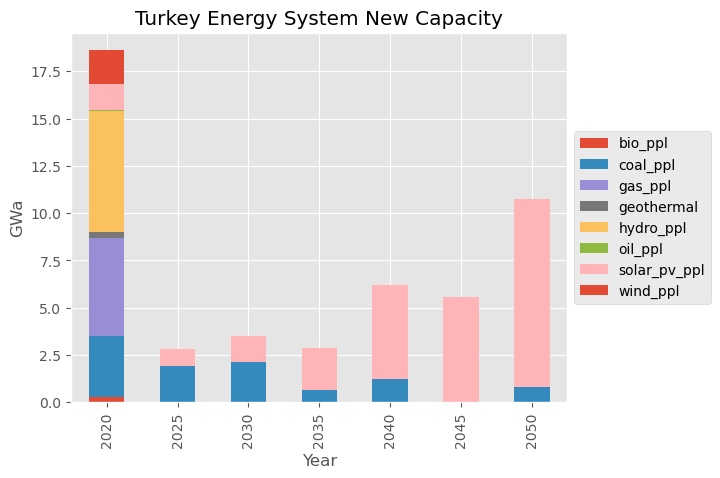

In [56]:
rep.set_filters(t=plants)
rep.get("plot new capacity")

<Axes: title={'center': 'Turkey Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

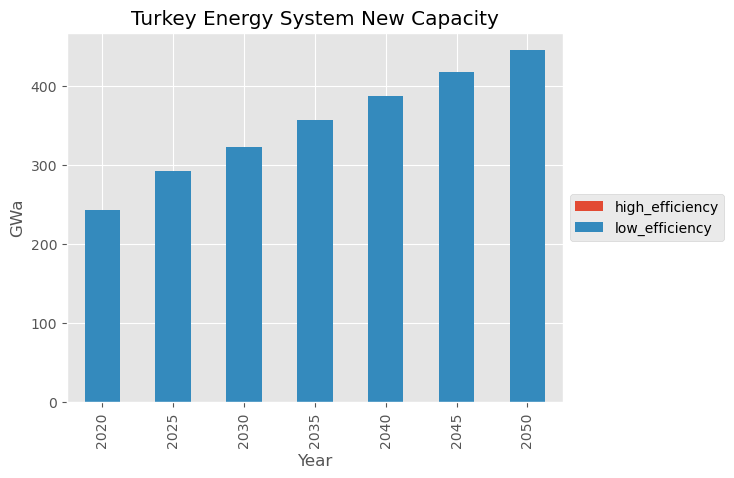

In [57]:
rep.set_filters(t=light_and_appliance)
rep.get("plot new capacity")

<Axes: title={'center': 'Turkey Energy System Capacity'}, xlabel='Year', ylabel='GW'>

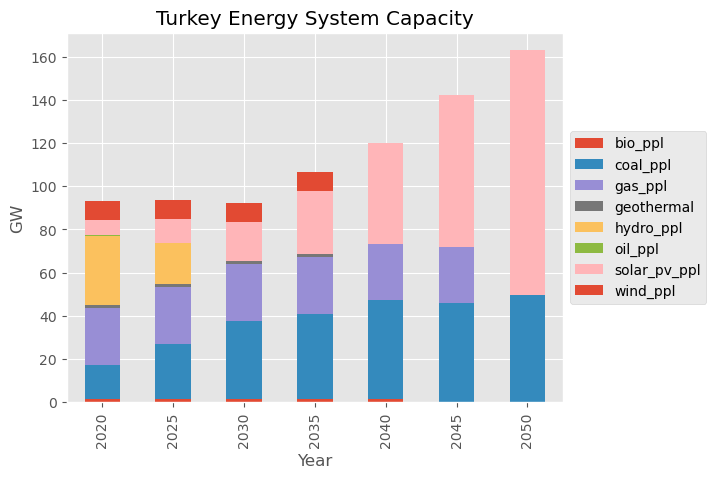

In [58]:
rep.set_filters(t=plants)
rep.get("plot capacity")

<Axes: title={'center': 'Turkey Energy System Capacity'}, xlabel='Year', ylabel='GW'>

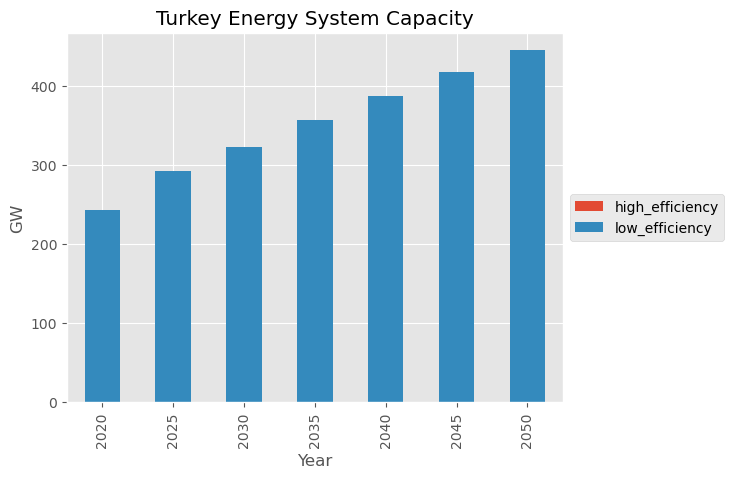

In [59]:
rep.set_filters(t=light_and_appliance)
rep.get("plot capacity")

genno.util - INFO: Add unit definition: GWa = [GWa]


<Axes: title={'center': 'Turkey Energy System Demand'}, xlabel='Year', ylabel='GWa'>

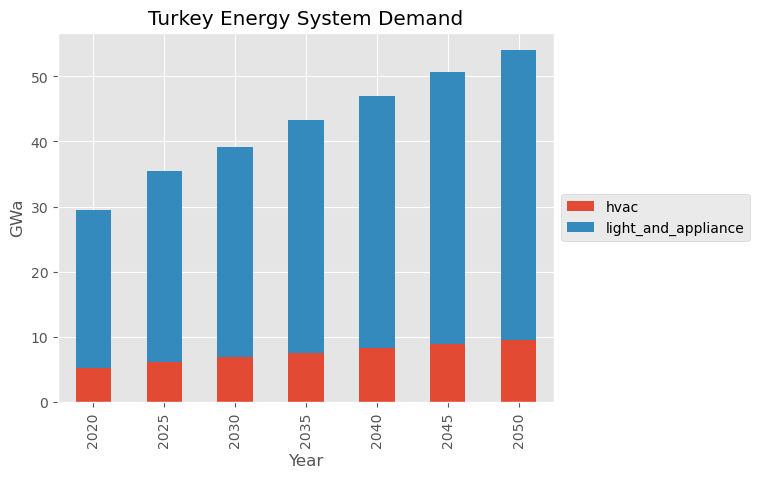

In [60]:
rep.get("plot demand")

<Axes: title={'center': 'Turkey Energy System Activity'}, xlabel='Year', ylabel='GWa'>

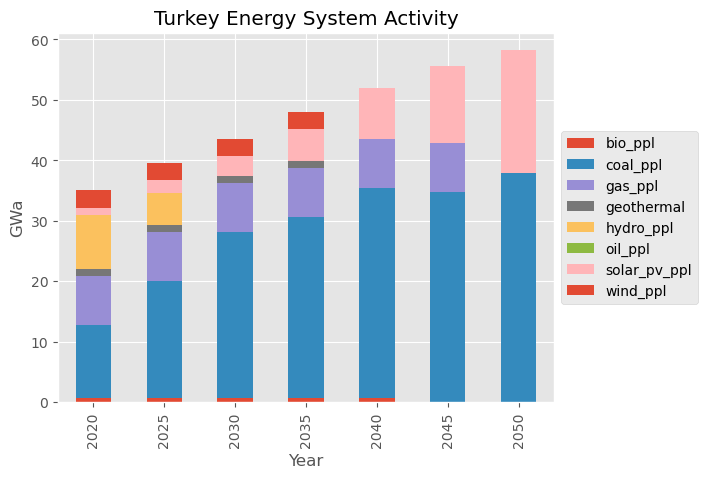

In [61]:
rep.set_filters(t=plants)
rep.get("plot activity")

<Axes: title={'center': 'Turkey Energy System Activity'}, xlabel='Year', ylabel='GWa'>

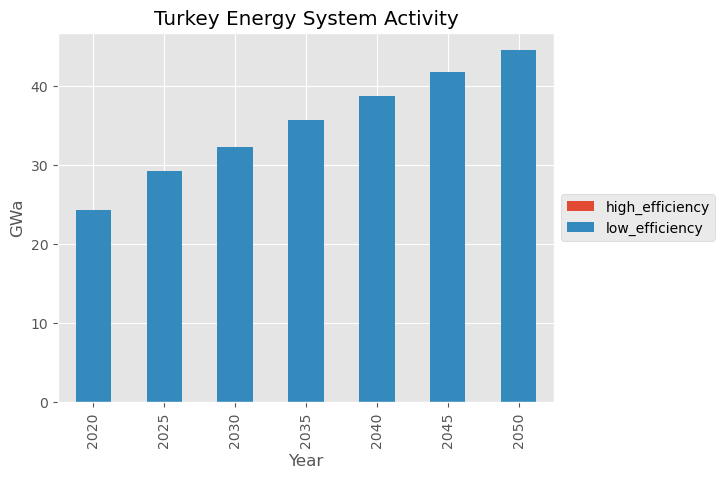

In [62]:
rep.set_filters(t=light_and_appliance)
rep.get("plot activity")

<Axes: title={'center': 'Turkey Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

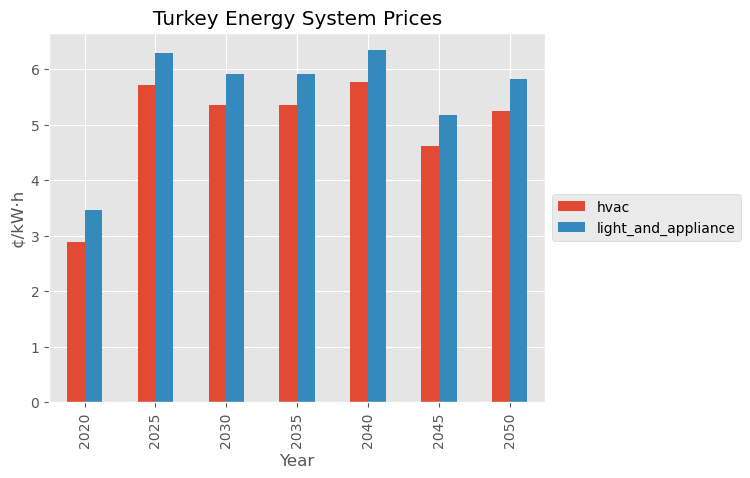

In [63]:
rep.set_filters(c=["light_and_appliance", "hvac"])
rep.get("plot prices")

In [108]:
from message_ix.report import Key
message_ix.report.Key?

Init signature:
message_ix.report.Key(
    name_or_value: Union[str, ForwardRef('Key'), ForwardRef('AnyQuantity')],
    dims: Iterable[str] = [],
    tag: Union[str, NoneType] = None,
    _fast: bool = False,
)
Docstring:      A hashable key for a quantity that includes its dimensionality.
File:           ~/miniconda3/envs/message_env/lib/python3.8/site-packages/genno/core/key.py
Type:           type
Subclasses:     

In [109]:
k1 = Key("a", ["i"])
k2 = Key("a", ["j", "k"])

(k1, k2)

(<a:i>, <a:j-k>)

In [104]:
message_ix.report.PYAM_CONVERT("fom")

TypeError: 'list' object is not callable

In [74]:
message_ix.report.get_tasks()

[(('map_addon', 'map_as_qty', 'cat_addon', 't'), {'strict': True}),
 (('map_emission', 'map_as_qty', 'cat_emission', 'e'), {'strict': True}),
 (('map_tec', 'map_as_qty', 'cat_tec', 't'), {'strict': True}),
 (('map_year', 'map_as_qty', 'cat_year', 'y'), {'strict': True}),
 (('out', 'mul', 'output', 'ACT'), {'strict': True}),
 (('in', 'mul', 'input', 'ACT'), {'strict': True}),
 (('rel', 'mul', 'relation_activity', 'ACT'), {'strict': True}),
 (('emi', 'mul', 'emission_factor', 'ACT'), {'strict': True}),
 (('inv', 'mul', 'inv_cost', 'CAP_NEW'), {'strict': True}),
 (('fom', 'mul', 'fix_cost', 'CAP'), {'strict': True}),
 (('vom', 'mul', 'var_cost', 'ACT'), {'strict': True}),
 (('land_out', 'mul', 'land_output', 'LAND'), {'strict': True}),
 (('land_use_qty', 'mul', 'land_use', 'LAND'), {'strict': True}),
 (('land_emi', 'mul', 'land_emission', 'LAND'), {'strict': True}),
 (('y::model', 'model_periods', 'y', 'cat_year'), {'strict': True}),
 (('y0', operator.itemgetter(0), 'y::model'), {'strict'

In [64]:
mp.close_db()

In [9]:
scenario.check_out()

In [8]:
scenario.remove_solution()